In [23]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  aiida@localhost


In [24]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups, WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, kkr_imp_sub_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, KkrCalculation ,VoronoiCalculation
import matplotlib.pyplot as plt

#from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr
#from aiida_kkr.tools import find_parent_structure, plot_kkr, kkrparams, neworder_potential_wf


In [25]:
#from aiida_kkr.workflows import kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, kkr_imp_sub_wc
#from aiida_kkr.calculations import KkrimpCalculation, KkrCalculation ,VoronoiCalculation



In [26]:
# DOS for host crystal
dos_ref = load_node('fd831449-2a37-4316-91e0-656829d69f7a')
# Dos from normalised weight
font = {'family': 'sans-serif',#'normal',
        'weight': 'normal',
        'size':20
       }

import matplotlib.pyplot as plt
import matplotlib as m
plt.rc('font',**font)
#cmap= m.cm.get_cmap('RdBu_r', 8)
colors = plt.cm.viridis(np.linspace(0.0, 0.9, 10))
colors = ['r', 'b', 'y', 'g','c']
plt.figure(figsize=(8,7))
dos = load_node('b2c6edee-92f6-4681-8346-c139abc84b13')

for i, label in zip([0,1,2,3,4],['Te1', 'Te2' ,'Te3', 'Bi1', 'Bi2']):
    kwargs = dict(silent=True, sum_spins=True, iatom= [i], color= colors[i], label= label, l_channels=False,
                  nofig=True, noshow=True, lw=0.5)
    plot_kkr(dos_ref, **kwargs)

plt.ylim(0.0)
plt.xlim((-2, 2))

NotExistent: no Node found with UUID<fd831449-2a37-4316-91e0-656829d69f7a>: No result was found

In [27]:
struc0 = load_node('c1626804-5b71-450c-91c4-aa7197d85279') # pk: 234  and uuid: c1626804-5b71-450c-91c4-aa7197d85279
#struc_0.get_pymatgen_structure()

In [28]:
## This function will help to plot dos_imp


def filter_out(node_list, process_label: str):
    com_wc_list = []
    for nod in node_list:
        try: 
            if nod.process_label == process_label:
                com_wc_list.append(nod)
        except NotExistent:
            continue
        except AttributeError:
            continue
    return com_wc_list
    
def dos_plot (group_or_wc_list):
    from aiida.orm import load_group, load_node
    if group_or_wc_list == []:
        dos_list= group_or_wc_list
    else:
        try:
            group = load_group(group_or_wc_list)
            node_list = list(group.nodes)
            node_list = filter_out(node_list, 'kkr_imp_dos_wc')
            dos_list = [i.pk for i in list(node_list)[:]]
        except:
            print('{} group is not present is the database.'.format(group_or_wc_list))

    for wc in dos_list[:]:
        imp_dos = load_node(wc)
        imp_info = imp_dos.label
        print(imp_info)


        fig2 = plt.figure(figsize=(15.0,4.5))
        spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)


        # Total contribution from the entire impurity cluster
        f2_ax1 = fig2.add_subplot(spec2[0, 0])
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True ,label= 'Impurity_Clu1ter',
                     noshow=True, nofig=True, color='C'+str(0), filled=True, alpha=0.3, yscale=1
                )
        # highlight the contibution of the impurity (iatom=0)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label= imp_dos.label,
                     noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0, 
                )        
            

        f2_ax2 = fig2.add_subplot(spec2[0, 1])
        plot_kkr(imp_dos, l_channels=True, strucplot=False, silent=True, label='Impurity_Cluster',
                noshow=True, nofig=True, color='C'+str(0),filled=True, alpha=0.3, yscale=1, sum_spins= True,)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
                noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)
        print('impurity_dict', imp_dos.inputs.impurity_info.get_dict())
        
                
## execution of the function
#dos_plot(94) #uuid-'ebe1fd31-89f7-4ca1-bf7f-0856940a7ad5', pk=94

In [29]:
""" 
For the given input 'imp_dos node or ID and intended energy points' it will return .
 Total density of states arround the indent eng points, most prominent orbital (s,p,d,...) 
 dos and corresponding dos value
"""
def dos_spec(imp_dos_or_pk, atom_index = 0, eng=0, dos= False, dos_interpol=False, debug=False):
    if not (dos or dos_interpol):
        return ('Please specify dos or interpol')
    elif dos and dos_interpol:
        return ('Please specify only one, dos or interpol')
    
    import numpy as np
    from aiida.orm import load_node
    from aiida.common.exceptions import NotExistent 
    from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation
    from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_wc
    
    is_id = None
    node_exist = None
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk


## Dos data
    if dos:
        dos_data = dos_node.outputs.dos_data
## Dos data from the dos_interpole
    if dos_interpol:
        dos_data = dos_node.outputs.dos_data_interpol
    dos_data_x = dos_data.get_x()
#     dos_data_x -->> ('E_EF', array([[30(15 atom * 2 spin)*96(energy_point)]]), unit)
    dos_data_y = dos_data.get_y()
#  dos_data_y -->>( (tot_dos, (30*96), unit), (s_dos, (30*96), unit), p, d, f, ((ns, (30*96), unit))
    
    if debug:
        print('dos_data_x shape :', np.shape(dos_data_x))
        print('dos_data_y shape :', np.shape(dos_data_y))
    
    # extract the discrete energy list and unit
    discrete_eng, eng_unit = (dos_data_x[1])[0][:], dos_data_x[2]
    if debug:
        print('discrete_eng : ',discrete_eng)
        print('eng_unit : ', eng_unit)
    
    dos_unit = dos_data_y[0][2]
    if debug:
        print('dos_unit : ', dos_unit)
    
    ## In this part only the required dos data will be saved into the dos_data_arr 
    # cut the dos data for total, s, p, ... into that array for tot, s, p, d, more orbital.
   
    # number of dos array e.g., tot, s, p,..orbital
    num = np.shape(dos_data_y)[0]
    if debug:
        print('NUM : ', num)
    
    y_grid = num*2 # to count the spin and down
    x_grid = len(discrete_eng)
    
    if debug:
        print('x_grid, :', x_grid)
        print('y_grid, :', y_grid)

    dos_data_arr = np.zeros((y_grid,x_grid),dtype=float)
    if debug:
        if num == int(y_grid/2):
            print('ok')

    ## The array dos_data_arr consist dos data for the <atom_index> and for all ldos (total, s, p....,ns)
    for i in range(num): 
        l_dos = dos_data_y[i][1]
        dos_data_arr[i*2][:] =  l_dos[atom_index*2][:] # for spin up
        dos_data_arr[i*2+1][:] =  l_dos[atom_index*2 +1][:] # for spin down 
    if debug:    
        print('dos_data_arr shape: ',np.shape(dos_data_arr))
    
    # Find the energy index nearest to eng index
    nearest_eng_point_index = min(range(len(discrete_eng)), key= lambda i : abs(discrete_eng[i] - eng))
    if debug:
        print('min energy : ', nearest_eng_point_index)
    
    ## It returns all the dos along the column at the index <nearest_eng_point_index>
#    all_dos = dos_data_arr.T[nearest_eng_point_index][:]
    all_dos = dos_data_arr[:,nearest_eng_point_index]
    
    if debug:
        print('shape of the all_dos', np.shape(all_dos))
        print('all_dos data : ',all_dos)

    
    ## total dos_density list at energy point <eng> for an atom <atom index>
    total_dos = [all_dos[0], all_dos[1]]
    ldos_u , ldos_d = ([all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==0 ],
                       [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==1 ])
    
    # To collecting the lebel from dos_data
    #collect the ldos lebel for max_dos spin up and spin down
    ldos_u_label = dos_data_y[np.argmax(ldos_u[:]) + 1][0] 
    ldos_d_label = dos_data_y[np.argmax(ldos_d[:]) + 1][0]
    
    # Collect the max ldos value 
    max_ldos_up_value = np.max(ldos_u)
    max_ldos_down_value = np.max(ldos_d)
    
    # To collec the data for further invetigation e.g. ploting 
    out_dict = {'dos': {'dos_spin_up': total_dos[0],
                                  'dos_spin_down': total_dos[1]},
                'Most Prominent_ldos': {ldos_u_label + '_spin_up': max_ldos_up_value,
                                      ldos_d_label + '_spin_down': max_ldos_down_value},
                'Units':{'energy_unit': eng_unit,
                         'dos_unit':dos_unit},
                'Other':{'eng':discrete_eng[nearest_eng_point_index],
                         'atom_index':atom_index}
               } 
    return out_dict
    

In [30]:
## This function will return the desired value from the last calc output_parameters for the given input parameter
## and also some out_parameters from the kkr_imp_scf wc
## DATA has been extructed from dos wc
def conv_dos_data(imp_dos_or_pk, debug= False, dos= False, dos_interpol= False):
    if not (dos or dos_interpol):
        return ('Please specify dos or interpol')
    elif dos and dos_interpol:
        return ('Please specify only one, dos or interpol')
    
    import numpy as np
    from aiida.orm import load_node
    from aiida_kkr.workflows import kkr_imp_sub_wc
    from aiida.common.exceptions import NotExistent 
    from aiida.common.constants import elements as elmt
    summary_data_dict = { 'rms_conv' : 0,
                          'etot_conv_Ry' : 0,
                          'etot_conv_eV' : 0,
                          'imp_spin_moment_mu_Bhor' : 0,
                          'imp_orbital_moment_mu_Bhor' : 0,
                          'imp_total_charge_electron' : 0,
                          'imp_core_charge_electron' : 0,
                          'charge_doping_electron' : 0, # 
                          'DOS_in_gap' : 0,
                     };
    imp_clst_dict = {'atoms_in_impurity_cluster' : 0,
                     'ilayer' : 0,
                     'Zimp' : 0,
                     'Zhost' : 0
                    }
    
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk
    imp_info = dos_node.inputs.impurity_info.get_dict()
    scf_wc = dos_node.inputs.imp_pot_sfd.get_incoming(node_class = kkr_imp_wc).first().node
    scf_out_param = scf_wc.outputs.last_calc_output_parameters.get_dict()
    
    # To extract the host structure from the using the host_Greenfunction_folder comingout from the kkr_flex_wc
    kkr_sub = dos_node.get_outgoing(node_class=kkr_imp_sub_wc).first().node
    kkrimp_calc = kkr_sub.get_outgoing(node_class= KkrimpCalculation).first().node
    host_greenfuntion_folder = kkrimp_calc.inputs.host_Greenfunction_folder
    host_structure, voro_calc = VoronoiCalculation.find_parent_structure(host_greenfuntion_folder)
    
    
    ## Filling the last calc output data
    imp_atom = 0
    dos_eng = 0
    summary_data_dict['rms_conv'] = scf_out_param['convergence_group']['rms']
    summary_data_dict['etot_conv_Ry'] = scf_out_param['total_energy_Ry']
    summary_data_dict['etot_conv_eV'] = scf_out_param['total_energy_Ry'] * 13.6056980659
    summary_data_dict['imp_spin_moment_mu_Bhor'] = scf_out_param['magnetism_group']['spin_moment_per_atom'][imp_atom][-1]
    summary_data_dict['imp_orbital_moment_mu_Bhor'] = scf_out_param['magnetism_group']['orbital_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_total_charge_electron'] = scf_out_param['total_charge_per_atom'][imp_atom]
    summary_data_dict['imp_core_charge_electron'] = scf_out_param['charge_core_states_per_atom'][imp_atom]
    charge_doping = imp_info['Zimp'] - summary_data_dict['imp_total_charge_electron']
    summary_data_dict['charge_doping_electron'] = charge_doping
    
    spec_dos_data = dos_spec(imp_dos_or_pk=dos_node, dos=dos, 
                             dos_interpol=dos_interpol, 
                             atom_index=imp_atom, eng=dos_eng,
                             debug=debug)
    dos_in_gap = spec_dos_data['dos']['dos_spin_up'] + spec_dos_data['dos']['dos_spin_down']
    summary_data_dict['DOS_in_gap'] = dos_in_gap

    
    # Filling the imp_cluster data
    cluster_size = len(scf_out_param['total_charge_per_atom'])
    zimp = imp_info['Zimp']
    zhost = 0 # TODO: Have to find it later
    ilayer = imp_info['ilayer_center']
    # To find the Zimp from the host structure
    sym_to_Znum = {val['symbol']:num for num,val in elmt.items() }
    ilayer_host_symbol = host_structure.sites[ilayer].kind_name
    zhost = sym_to_Znum[ilayer_host_symbol]
    
    
    
    
    
    imp_clst_dict['atoms_in_impurity_cluster'] = cluster_size
    imp_clst_dict['ilayer'] = ilayer
    imp_clst_dict['Zimp'] = zimp
    imp_clst_dict['Zhost'] = zhost
    return summary_data_dict, imp_clst_dict

In [31]:
# To plot some data

from aiida.common.constants import elements as elmt

group_ilayer_4 = load_group(107) # uuid: 84649009-607a-45c1-a56d-3d7f2593f434 (pk: 107)>
node_list = list(group_ilayer_4.nodes)


def gap_dos_spin_orbital_mom_plot_data(group_pk=None, debug= False):
    
    """
        inputs:
            group_pk : group kkr_imp_wc node to collect data for ploting
        retruns:
            truple(imp_list, gap_dos_list, spin_moment_list, orbital_moment_list): 
                        imp_list-> list of impurity symbol
                        gap_dos_list -> list density of states in gap
                        spin_mement_list -> spin momentum list of the impurities
                        orbiral_moment_list -> orbital momentum list of the impurities
    """
    
    if group_pk:
        LdGp = load_group(group_pk)
    else:
        raise TypeError('Please provide the group pk')
        
    node_list = list(LdGp.nodes)
    node_list = filter_out(node_list, 'kkr_imp_dos_wc')
    # All intended data list for ploting.
    imp_list = []
    gap_dos_list = []
    spin_moment_list = []
    orbital_moment_list = []

    #Hre collect the data for each imp_dos_calc
    for i in range(len(node_list)):
        dos_dict, clst_dict = conv_dos_data(imp_dos_or_pk=node_list[i],dos= True, dos_interpol=False, debug=False)
        imp_list.append(clst_dict['Zimp'])
        gap_dos_list.append(dos_dict['DOS_in_gap'])

        # Collect the spin moment
        spin_moment = dos_dict['imp_spin_moment_mu_Bhor']# pow(sum([i**2 for i in dos_dict['imp_spin_moment_mu_Bhor']]), 0.5) 
        spin_moment_list.append(spin_moment)

        # Collect the orbital moment
        orbital_moment = pow(sum([i**2 for i in dos_dict['imp_orbital_moment_mu_Bhor']]), 0.5)
        orbital_moment_list.append(orbital_moment)
    
    
    if debug:
        print('test gap_do_list :', gap_dos_list)
        print('test spin_moment_list :', spin_moment_list)
        print('test orbital_moment_list :', orbital_moment_list)
    
    return (imp_list, gap_dos_list, spin_moment_list, orbital_moment_list)



['Y', 'Pd', 'Cd', 'Ag', 'V', 'Cr', 'Fe', 'Mo', 'Co', 'Zr', 'Ru', 'Nb', 'Zn', 'Ni', 'Ti', 'Mn', 'Cu', 'Rh', 'Tc']


/tmp/ipykernel_2643694/271790408.py:53: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(imp_list_107, xlabel, Fontsize= 20)


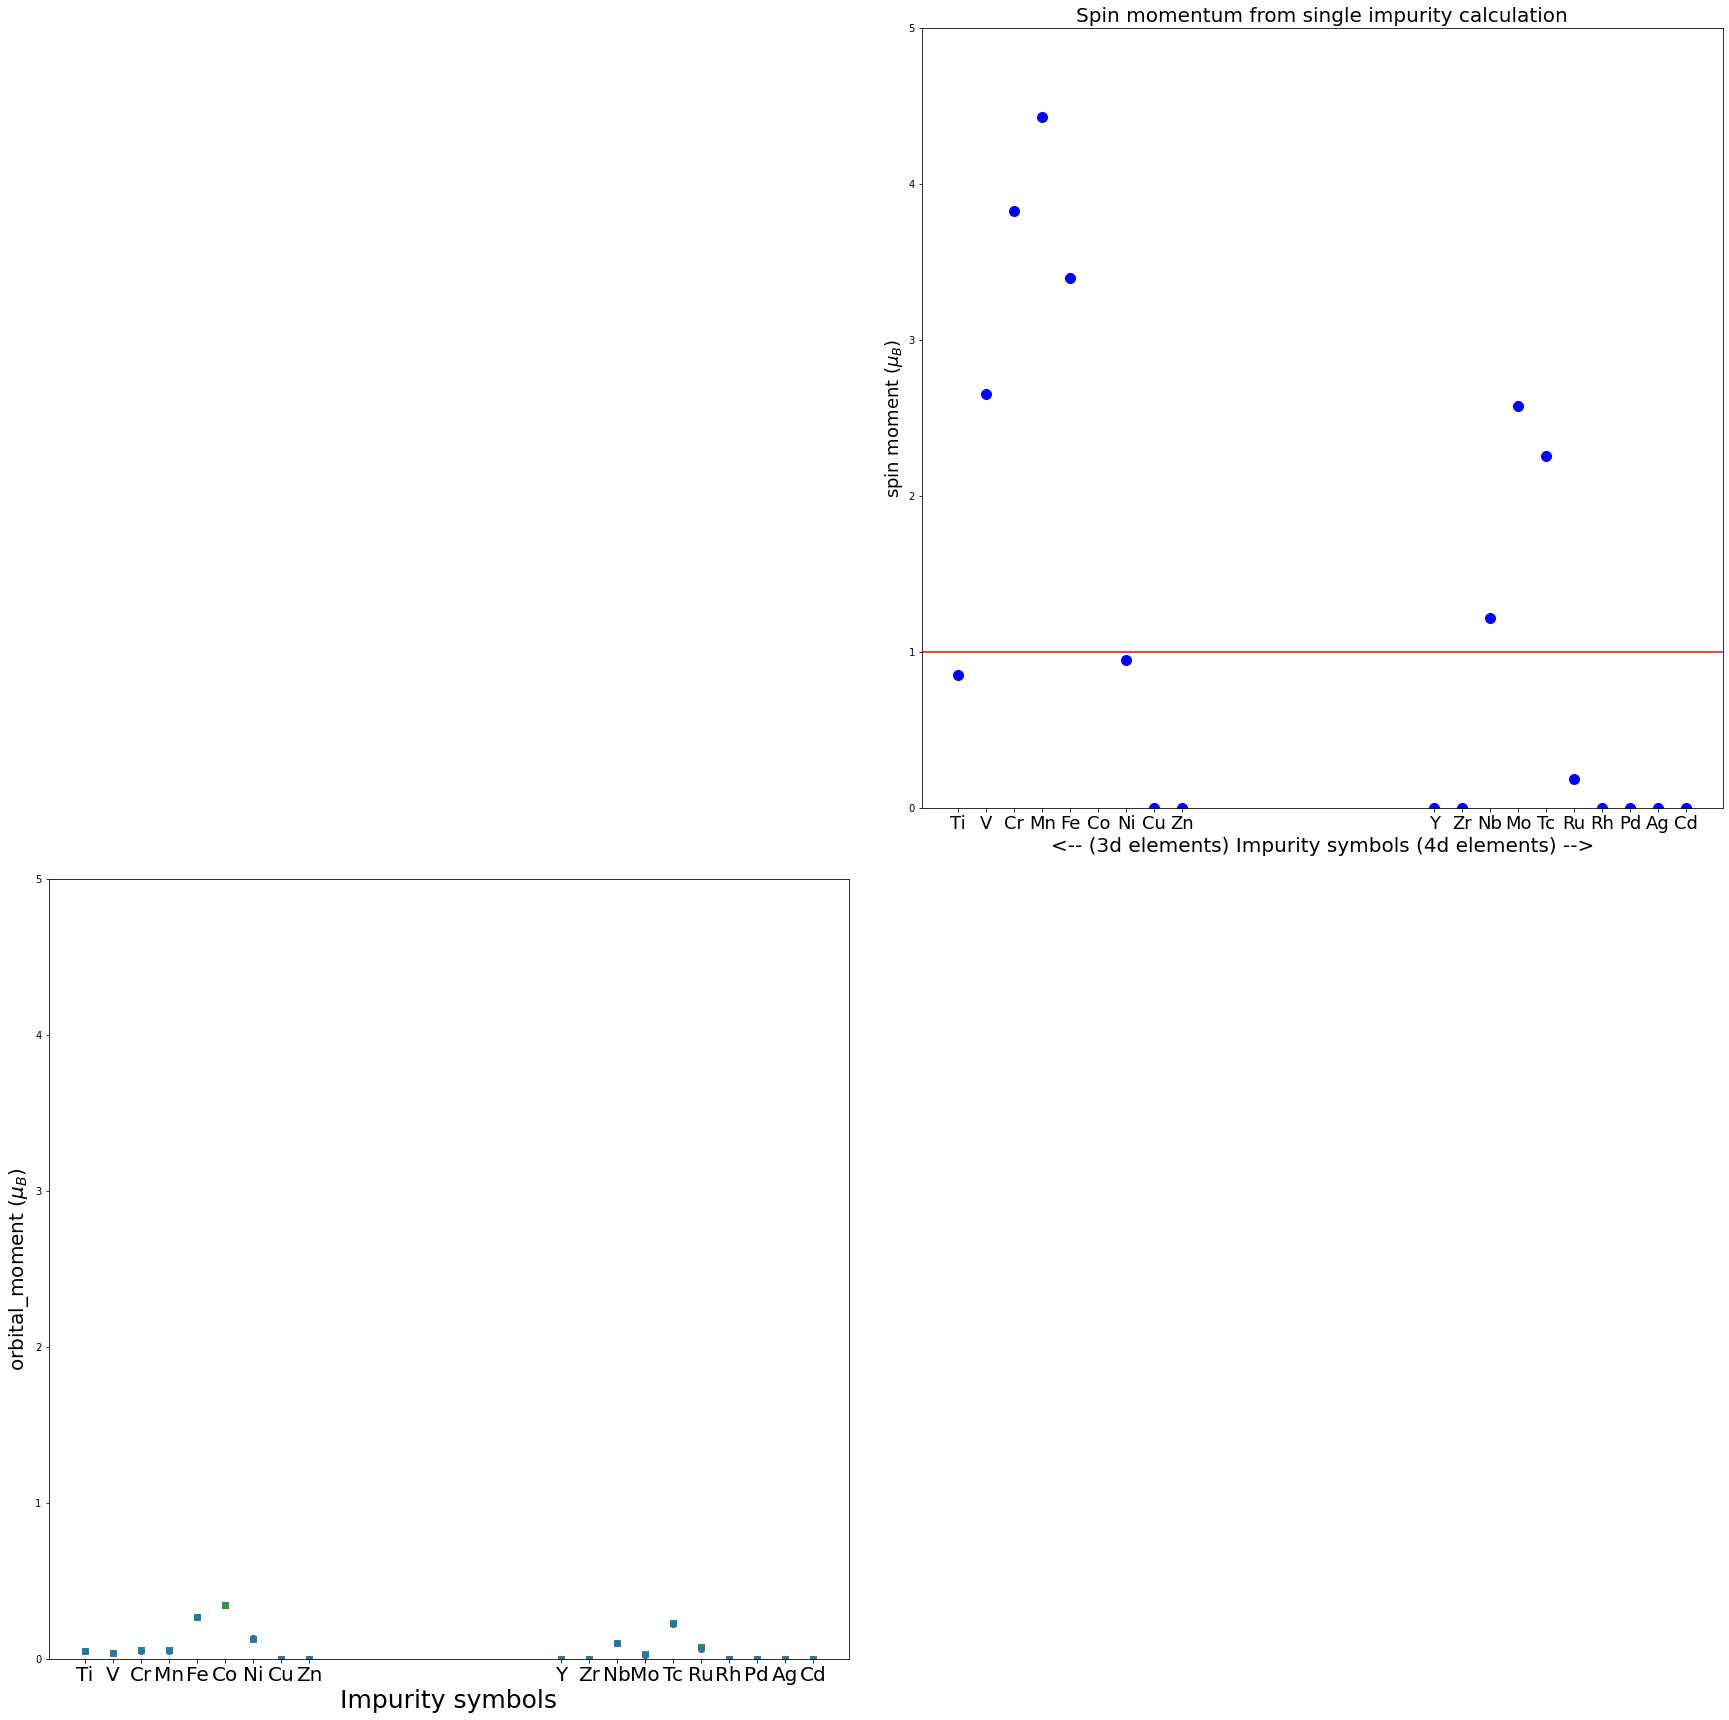

'4.557'

In [32]:
### To load the data from the group uncommand the following the code and run 
### the function gap_dos_spin_orbital_mom_plot_data

(imp_list_107, gap_dos_list_107, spin_moment_list_107, orbital_moment_list_107) = gap_dos_spin_orbital_mom_plot_data('84649009-607a-45c1-a56d-3d7f2593f434')
#108a56d-3d7f2593f434 (pk: 107)>
(imp_list_108, gap_dos_list_108, 
     spin_moment_list_108, orbital_moment_list_108) = gap_dos_spin_orbital_mom_plot_data('b79c67ed-3a2e-4cf9-878f-f6f16cf5d610')
     #grp: uuid:b79c67ed-3a2e-4cf9-878f-f6f16cf5d610  (pk: 108)>

     ## Plot some out_put_data Vs imp

#imp_list = imp_list_108
plt.figure(figsize=(30,30))

plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
#plt.scatter(imp_list_107, np.array(spin_moment_list_107), marker='o',s=100, color= 'b')

imp_arr = np.array(imp_list_108)

for i in range(len(imp_list_108)):
    if imp_list_108[i]>30:
        imp_arr[i] -= 10


## plot      
plt.scatter(imp_list_108, spin_moment_list_108, marker='o', s=100, color='b')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Spin momentum from single impurity calculation', fontsize= 20)
plt.xlabel('<-- (3d elements) Impurity symbols (4d elements) -->',  fontsize= 20)
plt.ylabel('spin moment ($\mu_B$)', fontsize= 18)
plt.ylim((0.0,5.0))
plt.axhline(1, color='r', label='2.5')
#plt.text(21,1, '1.0', color='r', ha='right', va='center')
xlabel = [elmt[i]['symbol'] for i in imp_list_107[:]]
print(xlabel)
plt.xticks(imp_list_107, xlabel, fontsize=18)


ax = plt.subplot2grid((4,4), (2,0), colspan=2, rowspan=2)
ax.scatter(imp_list_107, orbital_moment_list_107, marker='s')
ax.scatter(imp_list_108, np.array(orbital_moment_list_108), marker='o')

ax.plot(imp_list_108, orbital_moment_list_108, 'o')
ax.scatter(imp_list_107, orbital_moment_list_107, )
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
#plt.title('imp_spin_moment Vs imp')
plt.xlabel('Impurity symbols',  fontsize=25)
plt.ylabel('orbital_moment ($\mu_B$)',  fontsize=20)
plt.ylim((0.0,5.0))
xlabel = [elmt[i]['symbol'] for i in imp_list_107[:]]
plt.xticks(imp_list_107, xlabel, Fontsize= 20)


plt.show()
'%.3f'%(4.5574844)

In [16]:
len(xlabel)

0

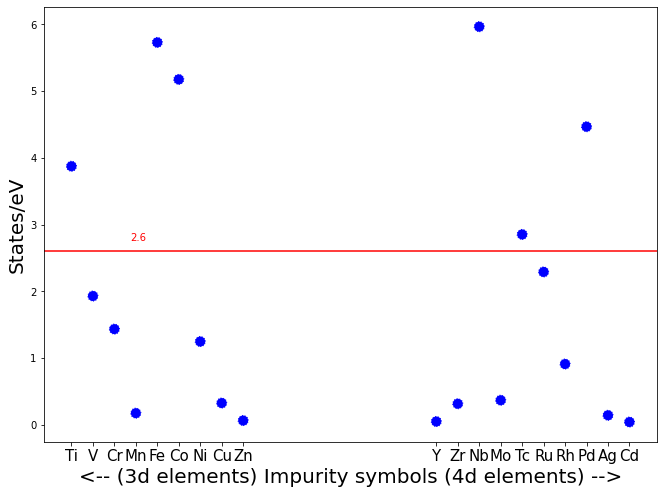

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
plt.figure(1, figsize=(11,8))
gdspec.GridSpec(1,1)

# Plot DOS in gap Vs imp
plt.subplot2grid((1,1), (0,0), colspan=2, rowspan=2)

plt.scatter(imp_list_107, gap_dos_list_107, marker= 'o', s= 100, color='b', ls=':')
#plt.scatter(imp_list_108, gap_dos_list_108, marker= 's', s= 100, color='b', ls=':')
#plt.plot(np.arange(len(imp_list_108)), gap_dos_list_108, marker= 's',color='b', ls=':')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=10)
#plt.title('DOS at Fermi level',  fontsize=20)
plt.xlabel('<-- (3d elements) Impurity symbols (4d elements) -->',  fontsize=20)
plt.ylabel('States/eV',  fontsize=20)
plt.axhline(2.6, color='r', label='2.6')
xlabel = [elmt[i]['symbol'] for i in imp_list_107[:]]
plt.text(25.5, 2.8, '2.6', color='r', ha='right', va='center')
plt.xticks(imp_list_107, xlabel, fontsize= 15)
file_name = 'DOS_3_il.png'
plt.savefig(file_name, dpi=300)
#plt.legend()

In [13]:
[elmt[i]['symbol'] for i in imp_list_107[:]]

['Y',
 'Zr',
 'Mo',
 'Nb',
 'Cu',
 'Tc',
 'Ti',
 'V',
 'Ru',
 'Cr',
 'Mn',
 'Rh',
 'Fe',
 'Ag',
 'Co',
 'Cd',
 'Ni',
 'Pd',
 'Zn']

In [40]:
## Plot 2D data from combine impurity
group_102 = load_group('762e0df8-6313-460f-b97b-77b68363b878') # uuid: 762e0df8-6313-460f-b97b-77b68363b878, pk: 102,grp_label: 3d_4d_dope_Bi2Te3_il_3:il_3_offset_1
def TwoDData_extract(group):
    combine_imps_group = load_group(group)
    combine_nodes_list = list(combine_imps_group.nodes)
    combine_nodes_list = filter_out(combine_nodes_list, 'combine_imps_wc')#'combine_imps_wc'
    time_per_iter = list()
    for node in combine_nodes_list[:]:
        
        last_calc_param = node.outputs.last_calc_output_parameters.get_dict()
        ## To extract the iteration time per iter
        total_running_time = last_calc_param['timings_group']['Total running time']
        total_iter = last_calc_param['convergence_group']['number_of_iterations']
        per_iter = total_running_time/total_iter
        
        time_per_iter.append(per_iter)
    
    return time_per_iter
        
        ##
time_per_iter = TwoDData_extract('762e0df8-6313-460f-b97b-77b68363b878')



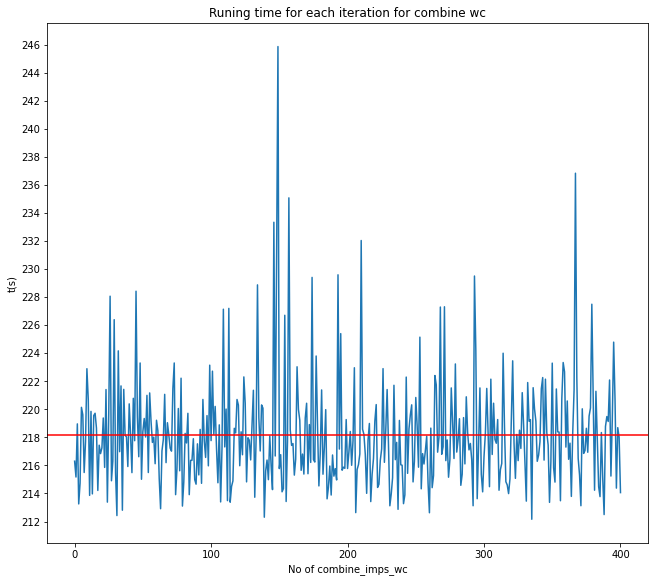

In [41]:
## Plot some out_put_data Vs imp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(15*1.5,20))
gdspec.GridSpec(4,4)

# Plot DOS in gap Vs imp

plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
plt.plot(time_per_iter)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=20)
plt.title('Runing time for each iteration for combine wc')
plt.xlabel('No of combine_imps_wc')
plt.ylabel('t(s)')
plt.axhline(np.average(time_per_iter), c='RED')
# xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
# plt.xticks(imp_list, xlabel)

plt.savefig('runtime for iteration.pdf', dpi=100.0, pad_inches=.05)
plt.show()


In [18]:
# diamar_plot(104,)

node label :  Pd:Bi2Te3dos_(-1,1)
node pk :  85637
color and ls :  b and --
node label :  V:Bi2Te3dos_(-1,1)
node pk :  85390
color and ls :  g and -
node label :  Cr:Bi2Te3dos_(-1,1)
node pk :  85651
color and ls :  r and :
node label :  Fe:Bi2Te3dos_(-1,1)
node pk :  85653
color and ls :  c and --
node label :  Mo:Bi2Te3dos_(-1,1)
node pk :  85406
color and ls :  m and -
node label :  Co:Bi2Te3dos_(-1,1)
node pk :  85664
color and ls :  y and :
node label :  Ru:Bi2Te3dos_(-1,1)
node pk :  85562
color and ls :  k and --
node label :  Nb:Bi2Te3dos_(-1,1)
node pk :  85573
color and ls :  b and -
node label :  Mn:Bi2Te3dos_(-1,1)
node pk :  85231
color and ls :  g and :
node label :  Rh:Bi2Te3dos_(-1,1)
node pk :  85239
color and ls :  r and --


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


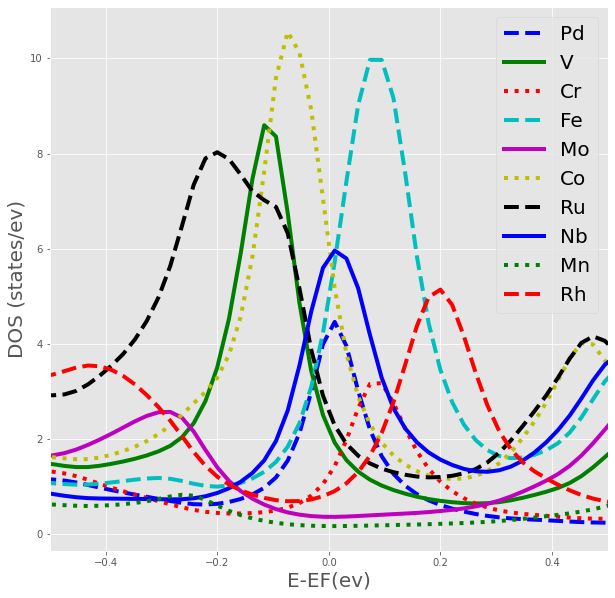

In [49]:
#plot_kkr

font = {'family':'normal',
        'weight': 'normal',
        'size':20
       }

# uuid: 84649009-607a-45c1-a56d-3d7f2593f434, pk: 107,grp_label: 3d_4d_dopants_Bi2Te3_ilayer_3_dos_zoom
# uuid: b79c67ed-3a2e-4cf9-878f-f6f16cf5d610, pk: 108,grp_label: 3d_4d_dopants_Bi2Te3_ilayer4_dos_zoom

plot_group1= filter_out(list(load_group('84649009-607a-45c1-a56d-3d7f2593f434').nodes), 'kkr_imp_dos_wc')
plot_group2= filter_out(list(load_group('b79c67ed-3a2e-4cf9-878f-f6f16cf5d610').nodes), 'kkr_imp_dos_wc')

plt.figure(figsize=(10,10))
#plt.figure(figsize=(10,10))

list_4d_atom= ['Pd', 'Nb', 'Mo', 'Ru', 'Rh']
list_3d_atom= ['Fe', 'Co', 'V', 'Cr','Mn']
#list_4d_atom= ['Tc','Ru']#['Y','Zr','Mo','Nb','Tc','Ru','Rh','Ag','Cd','Pd']
#list_3d_atom= ['Sc', 'V', 'Cr', 'Mn', 'Ti', 'Co', 'Cu', 'Zn',  'Ni',   'Fe']

ls = ['--', '-', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

i= 0
for node_ in plot_group1:
    imp = node_.label.split(':')[0]
    if imp in list_3d_atom + list_4d_atom:
        print('node label : ', node_.label)
        print('node pk : ', node_.pk)
        print('color and ls : ',colors[i%7], 'and', ls[i%3])
        
        dos_data = node_.outputs.dos_data
        plot_kkr(node_, strucplot= False, interpol=False, iatom=0, ls= ls[i%3],  
                 label= imp, color= colors[i%7], silent= True, 
                 sum_spins= True, l_channels= False, nofig=True, 
                 noshow= True, lw= 4)# title= None)
        i += 1
plt.rc('font', **font)
#plt.axvline(0.0105)
#plt.axhline(1.5)
plt.xlim(-0.5,0.5)
plt.xlabel('E-EF(ev)',fontsize=20)
plt.ylabel('DOS (states/ev)',fontsize=20)
plt.title(label= None)
plt.legend(fontsize= 20, loc=1, ncol=1)
#plt.show()
plt.savefig('dos_ilayer_3.pdf', bbox_inches= 'tight', dpi=300)

In [ ]:
#plot_kkr

#Node for host DOS
dos_ref = load_node('fd831449-2a37-4316-91e0-656829d69f7a')

font = {'family':'normal',
        'weight': 'normal',
        'size':20
       }
# uuid: 84649009-607a-45c1-a56d-3d7f2593f434, pk: 107,grp_label: 3d_4d_dopants_Bi2Te3_ilayer_3_dos_zoom
# uuid: b79c67ed-3a2e-4cf9-878f-f6f16cf5d610, pk: 108,grp_label: 3d_4d_dopants_Bi2Te3_ilayer4_dos_zoom
plot_group1= load_group(107)
plot_group2= load_group(108)
plot_group1= filter_out(list(plot_group1.nodes), 'kkr_imp_dos_wc')
plot_group2= filter_out(list(plot_group2.nodes), 'kkr_imp_dos_wc')
plt.figure(figsize=(10,10))
#plt.figure(figsize=(10,10))

list_4d_atom= ['Pd', 'Nb', 'Mo', 'Ru', 'Rh']
list_3d_atom= ['Fe', 'Co', 'V', 'Cr','Mn']
#list_4d_atom= ['Tc','Ru']#['Y','Zr','Mo','Nb','Tc','Ru','Rh','Ag','Cd','Pd']
#list_3d_atom= ['Sc', 'V', 'Cr', 'Mn', 'Ti', 'Co', 'Cu', 'Zn',  'Ni',   'Fe']

ls = ['--', '-', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plot_kkr(dos_ref, strucplot=False, interpol=False,sum_spins=True,
         label='host', silent= True, l_channels=False, filled= True,
         alpha=0.3,
         nofig=True,noshow= True)
i= 0
for node_ in list(plot_group1.nodes)[:]:
    imp = node_.label.split(':')[0]
    if imp in list_3d_atom + list_4d_atom:
        
        dos_data = node_.outputs.dos_data
        plot_kkr(node_, strucplot= False, interpol=False, iatom=0, ls= ls[i%3],  
                 label= imp, color= colors[i%7], silent= True, alpha=1, 
                 sum_spins= True, l_channels= False, nofig=True, 
                 noshow= True, lw= 2)# title= None)
        i += 1
plt.rc('font', **font)
#plt.axvline(0.0105)
#plt.axhline(1.5)
plt.xlim(-.75,.75)
plt.xlabel('E-EF(ev)',fontsize=20)
plt.ylabel('DOS (states/ev)',fontsize=20)
plt.title(label= None)
plt.legend(fontsize= 15, loc=1, ncol=1)
#plt.show()
plt.savefig('dos_ilayer_3.pdf', bbox_inches= 'tight', dpi=300)